# Introduction.

- **History.**
  - 2025.04.06, 1st posting.
- **Library.**
  - `sklearn`, 1.6.1.
  - https://scikit-learn.org/stable/supervised_learning.html

# 0. Setup.

In [1]:
# Imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Verbose.
verbose = True
vprint  = print if verbose else lambda *a, **k: None

# Seed.
SEED    = 42

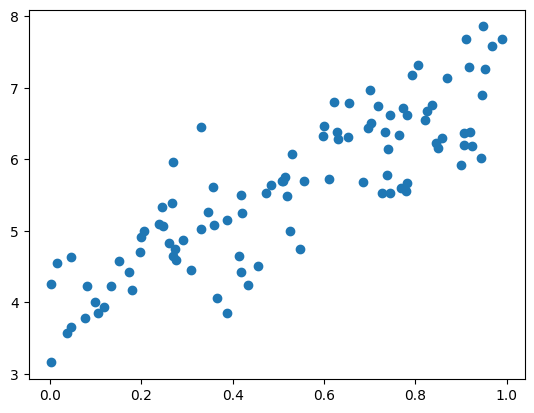

In [2]:
# Sample data.
X = np.random.rand(100, 1)
y = 3*X + 4 + np.random.randn(100, 1) / 2

plt.scatter(X, y)

# 1. Linear Models.

- $\hat{y} = w_0 + w_1x_1 + ... + w_kx_k$
- $w^T = <w_1, w_2, ..., w_k> = $ `'coef_'`
- $w_0 = $ `'intercept_'`

## 1.1. `LinearRegression`: Ordinary Least Square.

- Objective: $\min\limits_{w} ||Xw - \bar{y}||^2_2$
- Time Complexity (SVD): $O(m \cdot n^2)$, where $m \geq n$.

#### Signature.

```python
from sklearn.linear_model import LinearRegression

LinearRegression(
    *,
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False,
)

Ordinary least squares Linear Regression.
```

#### Example.

In [3]:
from sklearn.linear_model import LinearRegression

# Model.
model_lin = LinearRegression(fit_intercept  = True,   # if False, the data is expected to be centered.
                             positive       = True)   # force all coef_ to be positive.

# Fit.
model_lin.fit(X, y)

vprint(model_lin.coef_)
vprint(model_lin.intercept_)

[[3.19031515]]
[3.92588268]


## 1.2. `Ridge`: L2 Regularization.

- Objective: $\min\limits_{w} ||Xw - \bar{y}||^2_2 + \alpha||w||^2_2$
- Time Complexity: $O(m \cdot n^2)$, where $m \geq n$.
- If $\alpha$ becomes large, $w$s become even, i.e. more robust to collinearlity.
- If you are unsure about $\alpha$, use `RidgeCV` so that the model can choose the $\alpha$.

> Note) The `RidgeClassifier` can be significantly faster than e.g. `LogisticRegression` with a high number of classes because it can compute the projection matrix only once.

#### Signature.

```python
from sklearn.linear_model import Ridge, RidgeCV

Ridge(
    alpha=1.0,
    *,
    fit_intercept=True,
    copy_X=True,
    max_iter=None,
    tol=0.0001,
    solver='auto',
    positive=False,
    random_state=None,
)

Linear least squares with l2 regularization.
```

#### Example.

In [4]:
# Ridge.
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha = 1.0, random_state=SEED)

model_ridge.fit(X, y)

vprint(model_ridge.coef_)
vprint(model_ridge.intercept_)

# RidgeCV.
from sklearn.linear_model import RidgeCV

alphas = np.arange(0.1, 1.0, 0.1)
model_ridgeCV = RidgeCV(alphas=alphas, cv=10)

model_ridgeCV.fit(X, y)

vprint(f"Best alpha: {model_ridgeCV.alpha_}")

# RidgeClassifier and RidgeClassifierCV.
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

[2.8448492]
[4.1076643]
Best alpha: 0.2


## 1.3. `Lasso`: L1 Regularization.

- Objective: $\min\limits_{w} \frac{1}{2m} ||Xw - \bar{y}||^2_2 + \alpha||w||_1$
- Time Complexity: $O(m \cdot n^2)$, where $m \geq n$.

#### Signature.

```python
from sklearn.linear_model import Lasso, LassoCV

Lasso(
    alpha=1.0,
    *,
    fit_intercept=True,
    copy_X=True,
    max_iter=None,
    tol=0.0001,
    solver='auto',
    positive=False,
    random_state=None,
)

Linear least squares with l1 regularization.
```

> Note) Lasso tends to choose fewer non-zero coefficients, which could effectively reduce the number of features upon which the given solution is dependent.  
> It is also useful for `L1-based feature selection`.

#### Example - L1-based Feature Seleciton.

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

df = pd.read_csv('data/rainfall/train.csv.zip')
x  = df.drop(columns=['id', 'rainfall'])
y  = df['rainfall']

from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression(max_iter=1000, random_state=SEED)
model_logit.fit(x, y)

feature_selector  = SelectFromModel(model_logit, prefit=True)   # prefit=True => model is already fitted.
selected_features = feature_selector.get_support()

vprint(f"Before: {x.columns}")
vprint(f"After: {x.columns[selected_features]}")

Before: Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')
After: Index(['mintemp', 'dewpoint', 'cloud', 'sunshine'], dtype='object')


## 1.4. `ElasticNet`: L1 + L2 Regularization.

- Objective: $\min\limits_{w} \frac{1}{2m} ||Xw - \bar{y}||^2_2 + \alpha\rho||w||_1 + \frac{\alpha(1-\rho)}{2}||w||^2_2$
- Time Complexity: $O(m \cdot n^2)$, where $m \geq n$.

#### Signature.

```python
from sklearn.linear_model import ElasticNet, ElasticNetCV

ElasticNet(
    alpha=1.0,               # alpha.
    *,    
    l1_ratio=0.5,            # rho.
    fit_intercept=True,
    precompute=False,
    max_iter=1000,
    copy_X=True,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)

Linear regression with combined L1 and L2 priors as regularizer.
```

## 1.5. `LogisticRegression`: `LinearRegression` + `sigmoid`/`softmax`.

- Binary classification: $\hat{y} = \sigma(w^T x) = \frac{1}{1 + e^{-w^T x}}$
- Multiclass classification: $\hat{y}_i = \frac{e^{w_i^T x}}{\sum_j e^{w_j^T x}}$

#### Signature.

```python
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

LogisticRegression(
    penalty='l2',                   # penalty=  None | 'l1' | 'l2' | 'ElasticNet'
    C=1.0,                          # C = 1/alpha.
    l1_ratio=None,                  # l1_ratio = rho.
    *,
    dual=False,
    tol=0.0001,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='deprecated',
    verbose=0,
    warm_start=False,
    n_jobs=None,
)

Logistic Regression (aka logit, MaxEnt) classifier.
```

## 1.6. `SGDRegressor`: SGD.

#### Signature.

```python
from sklearn.linear_model import SGDRegressor, SGDClassifier

SGDRegressor(
    loss='squared_error',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    random_state=None,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    warm_start=False,
    average=False,
)

Linear model fitted by minimizing a regularized empirical loss with SGD.
```

## 1.7. Practice - Rainfall Prediction.

- https://www.kaggle.com/competitions/playground-series-s5e3/overview

### 1.7.1. `LogisticRegression` with defaults.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score

def fit_and_predict(df, model, verbose=False):
    vprint = print if verbose else lambda *a, **k: None

    x = df.drop(columns=['id', 'rainfall'])
    y = df['rainfall']
    
    # Train-Test Split.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
    
    # Feature Scaling.
    scaler = MinMaxScaler()
    x_train_prep = scaler.fit_transform(x_train)
    x_test_prep = scaler.transform(x_test)
    
    # Fit.
    model.fit(x_train_prep, y_train)
    
    # Predict.
    y_pred = model.predict(x_test_prep)
    
    # Calculate accuracy.
    acc = accuracy_score(y_test, y_pred)
    
    # For AUC, if model supports predict_proba, use probabilities; otherwise use predicted labels.
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test_prep)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = roc_auc_score(y_test, y_pred)
    
    vprint(f"{'Accuracy':<10}: {acc:.4f}")
    vprint(f"{'AUC':<10}: {auc:.4f}")
    
    return


In [7]:
# Data.
df = pd.read_csv('data/rainfall/train.csv.zip')
display(df.head(2))

# Model.
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression(max_iter=1000, random_state=SEED)

vprint('Model `LogisticRegression` with defaults:')
fit_and_predict(df, model_logit, verbose=verbose)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1


Model `LogisticRegression` with defaults:
Accuracy  : 0.8562
AUC       : 0.8685


### 1.7.2. Regularization.

In [8]:
from sklearn.linear_model import LogisticRegressionCV
model_logit_reg = LogisticRegressionCV(cv=10,
                                       Cs=np.arange(0.1, 0.9, 0.1),
                                       penalty='l2',                  # Since all features seem important.
                                       random_state=SEED)

vprint('Model `LogisticRegression` with L2 Regularization:')
fit_and_predict(df, model_logit_reg, verbose=verbose)

Model `LogisticRegression` with L2 Regularization:
Accuracy  : 0.8562
AUC       : 0.8671


### 1.7.3. Feature Selection using L1 Regularization.

In [9]:
from sklearn.feature_selection import SelectFromModel

feature_selector  = SelectFromModel(model_logit_reg, prefit=True)
selected_features = feature_selector.get_support()

x_selected = x.loc[:, selected_features]

vprint(f"Before: {x.columns}")
vprint(f"After: {x.columns[selected_features]}")

Before: Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')
After: Index(['dewpoint', 'humidity', 'cloud', 'sunshine'], dtype='object')


In [10]:
vprint('Before feature selection:')
fit_and_predict(df, model_logit_reg, verbose=verbose)

selected_feature_names = list(x.columns[selected_features])
df_selected = df[selected_feature_names + ['id', 'rainfall']]

vprint('\nAfter feature selection:')
fit_and_predict(df_selected, model_logit_reg, verbose=verbose)

Before feature selection:
Accuracy  : 0.8562
AUC       : 0.8671

After feature selection:
Accuracy  : 0.8425
AUC       : 0.8644


### 1.7.5. `SGDClassifier`.

In [11]:
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=SEED)

vprint('Before feature selection:')
fit_and_predict(df, model_sgd, verbose=verbose)

selected_feature_names = list(x.columns[selected_features])
df_selected = df[selected_feature_names + ['id', 'rainfall']]

vprint('\nAfter feature selection:')
fit_and_predict(df_selected, model_sgd, verbose=verbose)

Before feature selection:
Accuracy  : 0.8539
AUC       : 0.7864

After feature selection:
Accuracy  : 0.8493
AUC       : 0.7780
